[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ee-ortiz/ISIS-4825_202320_IMAGENES_Y_VISION/blob/main/Laboratorio%203/Taller/MISIS4825-M%26V2023%20-%20TALLER3.ipynb)

![image](https://drive.google.com/u/0/uc?id=15DUc09hFGqR8qcpYiN1OajRNaASmiL6d&export=download)

# Taller 3

En este taller, se exploraremos el uso de TensorFlow y Keras para el diseño y entrenamiento de redes neuronales perceptrón multicapa. Para ello utilizaremos el conjunto de datos **Alien vs. Predator**. El objetivo es construir un modelo de red neuronal que pueda clasificar correctamente las imágenes de acuerdo a su clase.

1\. **Preprocesamiento de Datos**

-   Implemente técnicas de preprocesamiento como normalización, estandarización y aumentación de datos utilizando TensorFlow y Keras.
-   Justifique cada técnica de preprocesamiento seleccionada y su impacto en el modelo de red neuronal.

2\. **Construcción de un Modelo de Red Neuronal Perceptrón Multicapa**

-   Desarrolle un modelo de red neuronal perceptrón multicapa utilizando Keras.
-   Discuta la elección de la arquitectura, incluyendo el número de capas, neuronas por capa, y funciones de activación.

3\. **Definición de Funciones de Callbacks para Monitorear el Entrenamiento**

-   Implemente funciones de callbacks en TensorFlow y Keras para monitorear el proceso de entrenamiento.
-   Explique cómo estas funciones pueden ayudar en la identificación de problemas como el sobreajuste o el entrenamiento insuficiente.
-   Justifique la selección de ciertos callbacks y su configuración.

4\. **Entrenamiento y Exploración de Resultados**

-   Detalle el proceso de entrenamiento, incluyendo la elección de la tasa de aprendizaje, el optimizador, y la función de pérdida.
-   Analice los resultados obtenidos, utilizando métricas de desempeño como precisión, recall, y F1-score.

Datos: [Alien vs. Predator images](https://www.kaggle.com/datasets/pmigdal/alien-vs-predator-images)

In [24]:
# Importación de librerías
import tensorflow as tf
from tensorflow import keras

In [25]:
# Instalación de Kaggle
!pip install kaggle --quiet


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\Asus\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


# 0\. **Exploración y previsualización de los datos.**

In [26]:
import json
import os
from kaggle.api.kaggle_api_extended import KaggleApi

# Asumiendo que el archivo 'kaggle.json' contiene tus credenciales de la API de Kaggle
# y está en el mismo directorio que este script.
with open('kaggle.json') as f:
    kaggle_credentials = json.load(f)

# Configuración de las variables de entorno con las credenciales de Kaggle
#os.environ['KAGGLE_USERNAME'] = kaggle_credentials['username']
#os.environ['KAGGLE_KEY'] = kaggle_credentials['key']
os.environ['KAGGLE_USERNAME'] = "juansebastianpinzon"
os.environ['KAGGLE_KEY'] = "20d42fb2c437b25a56d9baddb7a5aae8"

# Autenticación y descarga del conjunto de datos de Alien vs. Predator
api = KaggleApi()
api.authenticate()
api.dataset_download_files('pmigdal/alien-vs-predator-images', path='data', unzip=True)


OSError: Could not find kaggle.json. Make sure it's located in C:\Users\Asus\.kaggle. Or use the environment method.

In [27]:
import os
import matplotlib.pyplot as plt
from PIL import Image

def count_images(data_dir):
    """
    Cuenta el número total de imágenes y el número de imágenes por clase.
    
    :param data_dir: La ruta al directorio donde se encuentran los datos de entrenamiento.
    :return: Un diccionario con el conteo total y por clase.
    """
    total_images = 0
    counts = {}
    
    for class_dir in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_dir)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            total_images += num_images
            counts[class_dir] = num_images
            
    counts['total'] = total_images
    return counts

def plot_image_dimensions(data_dir):
    """
    Crea una gráfica de dispersión de las dimensiones de las imágenes.
    
    :param data_dir: La ruta al directorio donde se encuentran los datos de entrenamiento.
    """
    widths = []
    heights = []
    labels = []
    
    # Recolectar las dimensiones de las imágenes
    for class_dir in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_dir)
        if os.path.isdir(class_path):
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                with Image.open(image_path) as img:
                    w, h = img.size
                    widths.append(w)
                    heights.append(h)
                    labels.append(class_dir)
    
    # Crear la gráfica de dispersión
    plt.figure(figsize=(10, 8))
    for label in set(labels):
        idx = [i for i, x in enumerate(labels) if x == label]
        plt.scatter([widths[i] for i in idx], [heights[i] for i in idx], label=label)
    
    plt.title('Dispersión de las Dimensiones de las Imágenes')
    plt.xlabel('Ancho')
    plt.ylabel('Alto')
    plt.legend()
    plt.grid(True)
    plt.show()


def show_sample_images(data_dir, num_samples=5):
    """
    Muestra un conjunto de imágenes de muestra de cada clase.
    
    :param data_dir: La ruta al directorio donde se encuentran los datos de entrenamiento.
    :param num_samples: Número de muestras a mostrar de cada clase.
    """
    fig, axes = plt.subplots(nrows=num_samples, ncols=len(os.listdir(data_dir)), figsize=(10, num_samples))
    
    for i, class_dir in enumerate(os.listdir(data_dir)):
        class_path = os.path.join(data_dir, class_dir)
        if os.path.isdir(class_path):
            image_names = os.listdir(class_path)
            sample_images = image_names[:num_samples]
            
            for j, image_name in enumerate(sample_images):
                image_path = os.path.join(class_path, image_name)
                img = Image.open(image_path)
                axes[j, i].imshow(img)
                axes[j, i].axis('off')
                if j == 0:
                    axes[j, i].set_title(class_dir)
    
    plt.tight_layout()
    plt.show()

# Usar las funciones
data_directory = 'data/data/train'


## Conteo del dataset de imagenes

In [28]:

# Contar imágenes
image_counts = count_images(data_directory)
print(f"Image counts: {image_counts}")



Image counts: {'alien': 347, 'predator': 347, 'total': 694}


## Muestreo de imagenes por clase

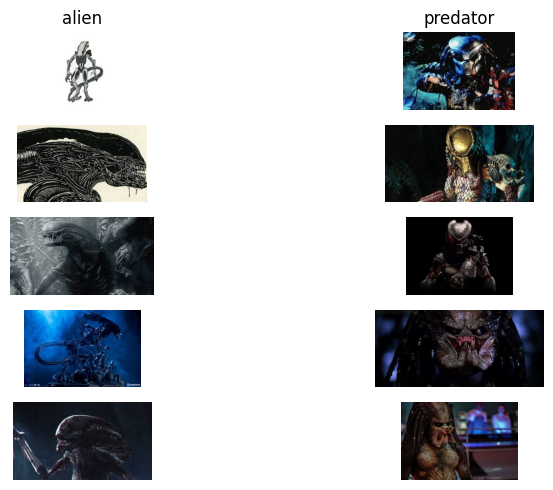

In [29]:
# Mostrar imágenes de muestra
show_sample_images(data_directory)

## Exploración de las dimensiones del dataset

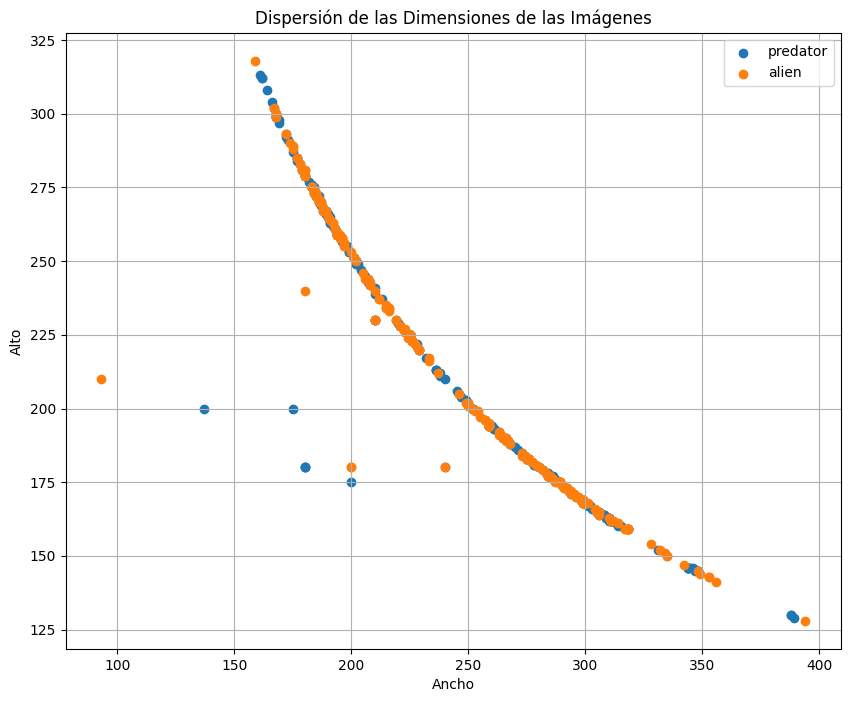

In [30]:
plot_image_dimensions(data_directory)


# 1\. **Preprocesamiento de Datos**

In [31]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

# Crear DataFrame a partir de las imágenes y los directorios
def create_dataframe(directory):
    data = []
    categories = os.listdir(directory)
    for category in categories:
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            images = os.listdir(category_path)
            for image in images:
                data.append({
                    'filepath': os.path.join(category_path, image),
                    'label': category
                })
    return pd.DataFrame(data)

# Crear DataFrames
train_directory = 'data/data/train'
validation_directory = 'data/data/validation'  # Asumiendo que ya tienes un directorio de validación
train_df = create_dataframe(train_directory)
validation_df = create_dataframe(validation_directory)

# Dividir conjunto de entrenamiento en entrenamiento y prueba
train_df, test_df = train_test_split(train_df, test_size=0.10, random_state=42)

train_df.head()


,filepath,label
227,data/data/train\alien\302.jpg,alien
2,data/data/train\alien\10.jpg,alien
630,data/data/train\predator\41.jpg,predator
81,data/data/train\alien\171.jpg,alien
380,data/data/train\predator\128.jpg,predator


## Generador de imagenes y normalización

In [32]:
# Tamaños del resize de las imagenes
image_size = (150, 150)
batch_size = 32 # Tamaño del batch

# Generadores para el train, test y val
train_datagen = ImageDataGenerator(
    rescale=1./255,  # normalización
    rotation_range=40,  # rotaciones aleatorias
    width_shift_range=0.2,  # traslaciones horizontales
    height_shift_range=0.2,  # traslaciones verticales
    shear_range=0.2,  # aplicaciones de cizallamiento
    zoom_range=0.2,  # aplicaciones de zoom aleatorio
    horizontal_flip=True,  # horizontal flip activo
    fill_mode='nearest'  # Estrategia de relleno para puntos fuera de los límites
)
test_val_datagen =  ImageDataGenerator(
    rescale=1./255,  # Normalización
    rotation_range=40,  # Rango en grados para rotaciones aleatorias
    width_shift_range=0.2,  # Rangos (como fracción del total) para traslaciones horizontales
    height_shift_range=0.2,  # Rangos para traslaciones verticales
    shear_range=0.2,  # Rango para aplicaciones de cizallamiento
    zoom_range=0.2,  # Rango para aplicaciones de zoom aleatorio
    horizontal_flip=True,  # Habilita el volteo horizontal
    fill_mode='nearest'  # Estrategia de relleno para puntos fuera de los límites
)

# Generadores de lectura de las imágenes de los directorios y de batches de datos
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    featurewise_center=True,
    featurewise_std_normalization=True,
)

test_gen = test_val_datagen.flow_from_dataframe(
    test_df,
    x_col='filepath',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary' ,
    featurewise_center=True,
    featurewise_std_normalization=True,
)

val_gen = test_val_datagen.flow_from_dataframe(
    validation_df,  
    x_col='filepath',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary',
    featurewise_center=True,
    featurewise_std_normalization=True,
)


Found 624 validated image filenames belonging to 2 classes.
Found 70 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.


### **Justificación del preprocesamiento**


1. **Normalización (rescale=1./255):**
    - Se normalizan los valores de los píxeles desde el rango de entrada de 0-255 a 0-1.  De esta forma es posible reducir (relativamente) la variabilidad en los datos y ayudará a su vez a la red neuronal a converger de forma más rápido en el entrenamiento. Lo anterior es graciias a que al reducir el rango de los datos de entrada, se puede hacer una reducción tambien en los rangos de variación de los pesos de las capas ocultas durante las actualizaciones del backpropagation. En otras palabras, reducir el reisgo de desvanecimiento de gradiente en las redes profundas. 
    


2. **Estandarización ( parámetros de featurewise_center y featurewise_std_normalization):** 
    - La estandarización nos permite ajustar la distribución de los píxeles para tener una media de cero y una desviación estándar de uno. Esto nos ayudará a mitigar la posible variación en terminos de escalas de los píxeles de nuestras imagenes. Puede ser util para el manejo de variaciones en las intensidades de nuestros datos de alien-predator, que al hacer el análisis exploratorio demostraron tener altas variaciones en terminos contrastes en las imagenes. 
    
    


3. **Aumentación de Datos:**
    - Introduce variabilidad en el conjunto de entrenamiento sin necesidad de recopilar más datos. Al aplicar las transformaciones geométricas y otras modificaciones a las imágenes, se crea un conjunto de datos más robusto. En terminos del modelo, puede mejorar la capacidad para generalizar a imágenes nuevas y no vistas, por lo cual termina siendo un proceso fundamental. Los procesos de aumentación que se hicieron fueron los siguientes:

        - Rotaciones Aleatorias (rotation_range=40)

        - Traslaciones Horizontales (width_shift_range=0.2)

        - Traslaciones Verticales (height_shift_range=0.2)

        - Aplicaciones de Cizallamiento (shear_range=0.2)

        - Aplicaciones de Zoom Aleatorio (zoom_range=0.2)

        - Volteo Horizontal (horizontal_flip=True)

        - Estrategia de Relleno (fill_mode='nearest')

# 2\. **Construcción de un Modelo de Red Neuronal Perceptrón Multicapa**

In [33]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout

# Definir el modelo
model = Sequential()

# Capa de flatten
model.add(Flatten(input_shape=image_size + (3,))) 

# Segunda capa densa con una activación ReLU
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4)) # Dropout para la regularización

# Primera capa densa con una activación ReLU
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))  # Dropout para la regularización



# Capa de salida binaria
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 67500)             0         
                                                                 
 dense_3 (Dense)             (None, 1024)              69121024  
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 dropout_4 (Dropout)         (None, 512)              

### Elección de la arquitectura:

- **Número de Capas y Neuronas:** Este modelo tiene dos capas ocultas. La primera capa oculta tiene 512 neuronas, y la segunda tiene 1024. Este número creciente de neuronas permite al modelo capturar más complejidad. Lo cual resulta de utilidad para modelos cuya entrada es de dimensiones grandes como en imágenes. Cabe resaltar que al tener un número grande de neuronas se podría correr con el riesgo al sobreajuste. 

- **Funciones de Activación:** Se utiliza la función de activación ReLU ('relu') en las capas ocultas porque suele ser eficiente y efectiva para la mayoría de entrenamientos en gran variedad de tareas. Del mismo modo, proporciona la capacidad de modelar respuestas no lineales sin caer en los problemas del gradiente desvaneciente (debido a lo facil que es calcular su gradiente y activación). Para la capa de salida, se utiliza la función de activación con 'sigmoide' puesto que al tratarse de un clasificador binario la sigmoide permite diferenciar con un valor de probabilidad entre 0 y 1 la pertenencia a la clase positiva (que se decide mayor a 0.5).

- **Regularización (Dropout):** Se añade el Dropout después de las capas densas para evitar el sobreajuste. Se desactivan aleatoriamente el 0.5 de neuronas durante el entrenamiento, lo que ayuda a que el modelo sea menos sensible a los datos de entrenamiento muy especificos (es decir que no memorice) y que mejorela generalización.

- **Optimizador:** Se elige 'adam' como optimizador, que ajusta automáticamente la tasa de aprendizaje durante el entrenamiento y generalmente funciona bien en la práctica para los modelos de redes profundas.

- **Función de Pérdida:** Para la compilación del modelo se usa 'binary_crossentropy', normalmente es la que se usa para clasificación binaria, pues permite dicernir la perdida para etiquetas binarias de la forma (0,1).

# 3\. **Definición de Funciones de Callbacks para Monitorear el Entrenamiento**


In [34]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import TensorBoard


early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorizar
    patience=10,         # Número de épocas sin mejora tras las cuales se detendrá el entrenamiento
    verbose=1,           # Muestra mensajes cuando se detiene el entrenamiento
    restore_best_weights=True  # Restaura los pesos del modelo desde la época con el mejor valor de la métrica monitoreada.
)

model_checkpoint = ModelCheckpoint(
    'best_model.h5',  # Nombre del archivo donde se guardarán los pesos
    monitor='val_loss',  # Métrica a monitorizar
    save_best_only=True,  # Solo guarda cuando la métrica monitorizada mejore
    verbose=1            # Muestra mensajes cuando se guarda el modelo
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Métrica a monitorizar
    factor=0.1,          # Factor por el cual se multiplicará la tasa de aprendizaje
    patience=5,          # Número de épocas sin mejora tras las cuales se reducirá la tasa de aprendizaje
    min_lr=0.001,        # Límite inferior de la tasa de aprendizaje
    verbose=1            # Muestra mensajes cuando se reduce la tasa de aprendizaje
)

tensorboard = TensorBoard(
    log_dir='./logs',  # Directorio donde se guardarán los logs
    histogram_freq=1,  # Frecuencia (en épocas) para calcular histogramas de activación
    write_graph=True,  # Si visualizar el grafo
    write_images=True, # Si visualizar imágenes de pesos
    update_freq='epoch' # Con qué frecuencia se escribirán los logs ('batch', 'epoch', o un número entero)
)


1\. **EarlyStopping:** 
- Detiene el entrenamiento cuando una métrica monitoreada ha dejado de mejorar.
- *Utilidad:* Ayudar a prevenir el sobreajuste al detener el entrenamiento antes de que la métrica de validación deje de mejorar durante un número especificado de épocas (patience). De esta forma, se garantiza que el modelo no se quede con pesos que se han empezado a sobreajustar.

2.\. **ModelCheckpoint:**
- Guarda el modelo después de cada época.
- *Utilidad:* Permite conservar el mejor modelo observado durante el entrenamiento según una métrica de rendimiento, de esta forma se puede guardar el modelo que actúa mejor en el conjunto de validación.


3.\. **ReduceLROnPlateau:** 
- Reduce la tasa de aprendizaje cuando una métrica ha dejado de mejorar.
- *Utilidad:* Ayuda a salir de los "plateau" durante el entrenamiento al reducir la tasa de aprendizaje, esto significa puntos en los que no hay cambios significativos de mejora en los entrenamientos. De esta forma se permite la posibilidad de una mejora continua en el rendimiento y metricas monitorizadas. 

4.\. **TensorBoard:**
- Habilita la visualización del proceso de entrenamiento.
- *Utilidad:* Permite el seguimiento y la visualización del proceso de entrenamiento y el rendimiento del modelo en tiempo real con el fin de identificar problemas relacionados con sobreajuste, problemas con la actualización de los pesos en el backpropagation o el entrenamiento insuficiente.

# 4\. **Entrenamiento y Exploración de Resultados**

### Entrenamiento del modelo construido junto a los callbacks

In [35]:
history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.n // batch_size,
    epochs=50,
    validation_data=val_gen,
    validation_steps=val_gen.n // batch_size,
    callbacks=[early_stopping, model_checkpoint, reduce_lr, tensorboard]
)


Epoch 1/50
19/19 [==============================] - ETA: 0s - loss: 13.6452 - accuracy: 0.5220
Epoch 1: val_loss improved from inf to 4.25236, saving model to best_model.h5
19/19 [==============================] - 90s 5s/step - loss: 13.6452 - accuracy: 0.5220 - val_loss: 4.2524 - val_accuracy: 0.5208 - lr: 0.0010
Epoch 2/50
19/19 [==============================] - ETA: 0s - loss: 4.7403 - accuracy: 0.4865
Epoch 2: val_loss improved from 4.25236 to 2.29268, saving model to best_model.h5
19/19 [==============================] - 77s 4s/step - loss: 4.7403 - accuracy: 0.4865 - val_loss: 2.2927 - val_accuracy: 0.4792 - lr: 0.0010
Epoch 3/50
19/19 [==============================] - ETA: 0s - loss: 1.5747 - accuracy: 0.5169
Epoch 3: val_loss improved from 2.29268 to 2.19223, saving model to best_model.h5
19/19 [==============================] - 100s 6s/step - loss: 1.5747 - accuracy: 0.5169 - val_loss: 2.1922 - val_accuracy: 0.4792 - lr: 0.0010
Epoch 4/50
19/19 [=============================

### Exploración de los resultados obtenidos

In [37]:
from sklearn.metrics import classification_report

# Supongamos que 'test_gen' es nuestro generador de datos de prueba.
# Primero debemos obtener las predicciones del modelo.
predictions = model.predict(test_gen, steps=test_gen.n // batch_size+1)
predicted_classes = predictions.argmax(axis=1)
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# Ahora, generamos el informe de clasificación.
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)


3/3 [==============================] - 0s 89ms/step
              precision    recall  f1-score   support

       alien       0.51      1.00      0.68        36
    predator       0.00      0.00      0.00        34

    accuracy                           0.51        70
   macro avg       0.26      0.50      0.34        70
weighted avg       0.26      0.51      0.35        70



C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: U